<a href="https://colab.research.google.com/github/desultir/assign1/blob/master/MNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
!pip install --upgrade scipy
!pip install --upgrade numpy


    100% |████████████████████████████████| 24.8MB 1.6MB/s 
imgaug 0.2.8 has requirement numpy>=1.15.0, but you'll have numpy 1.14.6 which is incompatible.
fastai 1.0.51 has requirement numpy>=1.15, but you'll have numpy 1.14.6 which is incompatible.
albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.8 which is incompatible.
  Found existing installation: scipy 1.1.0
    Uninstalling scipy-1.1.0:
      Successfully uninstalled scipy-1.1.0
    100% |████████████████████████████████| 17.3MB 2.1MB/s 
featuretools 0.4.1 has requirement pandas>=0.23.0, but you'll have pandas 0.22.0 which is incompatible.
datascience 0.10.6 has requirement folium==0.2.1, but you'll have folium 0.8.3 which is incompatible.
albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.8 which is incompatible.
  Found existing installation: numpy 1.14.6
    Uninstalling numpy-1.14.6:
      Successfully uninstalled numpy-1.14.6


In [0]:
import numpy as np
import matplotlib.pyplot as pl
from ipywidgets import interact, widgets
from matplotlib import animation
import h5py
from google.colab import drive
import time


In [0]:
drive.mount('/content/drive', force_remount=True)
with h5py.File('/content/drive/My Drive/Colab Notebooks/Input/train_128.h5','r') as H:
  data = np.copy(H['data'])
with h5py.File('/content/drive/My Drive/Colab Notebooks/Input/train_label.h5','r') as H:
  label = np.copy(H['label'])

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:

import pickle
import glob

model_dir = "/content/drive/My Drive/Colab Notebooks/Models/{}.pk"

def list_models():
  return glob.glob(model_dir.format("*"))




In [0]:
# need to normalize input data to avoid overflow/underflow in initial epochs
# normalize each feature independently
# options are zscore, minmax
def preprocess(input_array, method='zscore'):
  if method == 'zscore':
    for i in range(input_array.shape[1]):
      mean = np.mean(input_array[:, i])
      std = np.std(input_array[:, i])
      input_array[:, i] = (input_array[:, i] - mean) / std
  elif method == 'minmax':
    for i in range(input_array.shape[1]):
      # range 0 to max
      input_array[:, i] = (input_array[:, i] - np.min(input_array[:, i]))
      # range 0 to 2
      input_array[:, i] /= (np.max(input_array[:, i]) / 2)
      # range -1 to 1
      input_array[:, i] -= 1
      

In [0]:
#use stratified sampling to split train into train/validation
#this dataset is actually balanced but still good practice
def split(dataset, labels, train_percent=.85):
  count = len(dataset)
  num_classes = np.max(label) + 1
  train = []
  train_target = []
  validate = []
  validate_target = []
  for i in range(num_classes):
    class_data = np.ravel(np.argwhere(label == i))
    np.random.shuffle(class_data)
    cutoff = int(len(class_data) * train_percent)
    train_idx = class_data[:cutoff]
    val_idx = class_data[cutoff:]
    train.append(dataset[train_idx])
    train_target.append(labels[train_idx])
    validate.append(dataset[val_idx])
    validate_target.append(labels[val_idx])
    
  return np.vstack(train), np.hstack(train_target), np.vstack(validate), np.hstack(validate_target)

In [0]:
#need to one-hot encode labels to map to N output nodes (1 per class)
#ie convert each label into a (10,) vector where the relevant column is 1

def OHE(input_array, num_classes=10):
  output = []
  for x in input_array:
    output.append(np.zeros((10,)))
    output[-1][x] = 1
  return np.vstack(output)

In [0]:
## implemented formulae from here: https://towardsdatascience.com/hyper-parameters-in-action-part-ii-weight-initializers-35aee1a28404
class InitWeights(object):
  def xavier(self, n_in, n_out, uniform=True):
    if uniform:
      bounds = np.sqrt(6) / (np.sqrt(n_in + n_out))
      return self._uniform(n_in, n_out, bounds) 
    else:
      stddev = np.sqrt(2) / (np.sqrt(n_in + n_out))
      return self._truncated_normal(n_in, n_out, stddev)
    
  def he(self, n_in, n_out, uniform=True):
    if uniform:
      bounds = np.sqrt(2) / (np.sqrt(n_in))
      return self._uniform(n_in, n_out, bounds)      
    else:
      stddev = np.sqrt(6) / (np.sqrt(n_in))
      return self._truncated_normal(n_in, n_out, stddev)
 
  def _uniform(self, n_in, n_out, bounds):
    W = np.random.uniform(
        low=-bounds,
        high=bounds,
        size=(n_in, n_out)
      )
    return W
  
  def _truncated_normal(self, n_in, n_out, stddev):
    W = np.random.normal(
        loc=0,
        scale=stddev,
        size=(n_in, n_out)
      )
    #truncate results - anything > 2 stddev out gets clipped
    W[W> 2*stddev] = 2*stddev
    W[W<-2*stddev] = -2*stddev
    return W
  
  def __init__(self, init_method="xavier"):
    if init_method=="xavier":
      self.f = self.xavier
    elif init_method=="he":
      self.f = self.he

In [0]:
def calc_MSE(y, y_hat):
  error = y-y_hat
  return np.mean(np.sum(error**2, axis=1))

def labels_from_preds(preds):
  return np.argmax(preds, axis=1)

def calc_accuracy(labels, target):
  return np.sum(labels == target) / len(target)

#wasn't sure if we could use a package to shuffle so found this code: https://stackoverflow.com/questions/4601373/better-way-to-shuffle-two-numpy-arrays-in-unison
def shuffle_in_unison(a, b):
    assert len(a) == len(b)
    shuffled_a = np.empty(a.shape, dtype=a.dtype)
    shuffled_b = np.empty(b.shape, dtype=b.dtype)
    permutation = np.random.permutation(len(a))
    for old_index, new_index in enumerate(permutation):
        shuffled_a[new_index] = a[old_index]
        shuffled_b[new_index] = b[old_index]
    return shuffled_a, shuffled_b
  
  

The function for ReLU


$ f(x) = \begin{cases}
    x & \mbox{if } x > 0 \\
    0 & \mbox{otherwise}
\end{cases}$

The function for ReLU's derivative

$ f(x) = \begin{cases}
    1 & \mbox{if } x > 0 \\
    0 & \mbox{otherwise}
\end{cases}$


The function for Leaky ReLU


$ f(x) = \begin{cases}
    x & \mbox{if } x > 0 \\
    0.01x & \mbox{otherwise}
\end{cases}$

The function for ReLU's derivative

$ f(x) = \begin{cases}
    1 & \mbox{if } x > 0 \\
    0.01 & \mbox{otherwise}
\end{cases}$


In [0]:
from scipy.special import softmax

class Activation(object):
    def tanh(self, x):
        return np.tanh(x)

    def tanh_deriv(self, a):
        # a = np.tanh(x)   
        return 1.0 - a**2
    def logistic(self, x):
        return 1.0 / (1.0 + np.exp(-x))

    def logistic_deriv(self, a):
        # a = logistic(x) 
        return  a * (1 - a )
      
    def ReLU(self, x):
        x[x<0] =0
        return x
      
    def ReLU_deriv(self, a):
        der = np.zeros(a.shape)
        der[a>0] =1
        return der
      
    def leaky_ReLU(self, x):
        x = np.where(x > 0, x, x*0.01)
        return x
      
    def leaky_ReLU_deriv(self, a):
        der = np.full(a.shape, 0.01)
        der[a>0] =1
        return der
      
    def softmax(self, x):
        # apply max normalization to avoid overflow
        if len(x.shape) > 1:
          x_norm = (x.T - np.max(x, axis=1)).T
          return softmax(x_norm, axis=1)
        else:
          x_norm = x - np.max(x)
          return softmax(x_norm)
      
    def softmax_deriv(self, a):
        return np.ones(a.shape)
    
    def __init__(self,activation='tanh'):
        if activation == 'logistic':
            self.f = self.logistic
            self.f_deriv = self.logistic_deriv
        elif activation == 'tanh':
            self.f = self.tanh
            self.f_deriv = self.tanh_deriv
        elif activation == 'relu':
            self.f = self.ReLU
            self.f_deriv = self.ReLU_deriv
        elif activation == 'leaky_relu':
            self.f = self.leaky_ReLU
            self.f_deriv = self.leaky_ReLU_deriv
        elif activation == 'softmax':
            self.f = self.softmax
            self.f_deriv = self.softmax_deriv
            

In [0]:
class Loss_function(object):
    def MSE(self, y, y_hat):
        error = y-y_hat
        loss=np.sum(error**2)
        return loss
      
    def Cross_entropy(self, y, y_hat):
        return -np.log(y_hat[np.argmax(y)])
      
    def l2_reg(self, reg_weight, layers, sample_weight):
        accum = 0
        for layer in layers:
          accum += np.sum(np.square(layer.W))
          
        return accum*reg_weight*sample_weight/2
        
    def __init__(self,loss='cross_entropy'):
        if loss == 'MSE':
            self.loss = self.MSE
        elif loss == 'cross_entropy':
            self.loss = self.Cross_entropy

In [0]:

class HiddenLayer(object):    
    def __init__(self,n_in, n_out,
                 activation_last_layer='tanh',activation='tanh', W=None, b=None,
                init_uniform=True, weight_decay=None):
        """
        Typical hidden layer of a MLP: units are fully-connected and have
        sigmoidal activation function. Weight matrix W is of shape (n_in,n_out)
        and the bias vector b is of shape (n_out,).

        NOTE : The nonlinearity used here is tanh

        Hidden unit activation is given by: tanh(dot(input,W) + b)

        :type n_in: int
        :param n_in: dimensionality of input

        :type n_out: int
        :param n_out: number of hidden units

        :type activation: string
        :param activation: Non linearity to be applied in the hidden
                           layer
        :type init_uniform: bool
        :param init_uniform: Whether to draw init weights from uniform dist (else normal)
        
        :type weight_decay: float/None/False
        :param weight_decay: Weight to apply to l2 reg loss factor (else none/false)
        """
        self.input=None
        self.activation=Activation(activation).f
        
        if activation.contains('relu'):
          self.init_weights = InitWeights("he").f
        else:
          self.init_weights = InitWeights("xavier").f
        
        # activation deriv of last layer
        self.activation_deriv=None
        if activation_last_layer:
            self.activation_deriv=Activation(activation_last_layer).f_deriv

        if W is not None:
          self.W = W
        else:
          self.W = self.init_weights(n_in, n_out, init_uniform)

        if b is not None:
          self.b = b
        else:
          self.b = np.zeros(n_out,)  
          
        self.weight_decay = weight_decay
          
        self.grad_W = np.zeros(self.W.shape)
        self.grad_b = np.zeros(self.b.shape)
        
        # create arrays to store the velocity values for momentum calculation
        self.vW = np.zeros(self.W.shape)
        self.vb = np.zeros(self.b.shape)
        
    def forward(self, input):
        '''
        :type input: numpy.array
        :param input: a symbolic tensor of shape (n_in,)
        '''
        lin_output = np.dot(input, self.W) + self.b
        self.output = (
            lin_output if self.activation is None
            else self.activation(lin_output)
        )
        self.input=input
        return self.output
    
    def backward(self, delta, output_layer=False, sampleweight=1):
        self.grad_W = np.atleast_2d(self.input).T.dot(np.atleast_2d(delta))
        
        if self.weight_decay:
          self.grad_W += self.W * self.weight_decay * sampleweight
        self.grad_b = np.sum(delta, axis=0)
        if self.activation_deriv:
            delta = delta.dot(self.W.T) * self.activation_deriv(self.input)
        return delta
      

In [0]:

class MLP:
    """
    """      
    def __init__(self, layers=None, activation=[None,'tanh','tanh'], init_uniform=True, weight_decay=False, from_file=None):
        """
        :param layers: A list containing the number of units in each layer.
        Should be at least two values
        :param activation: The activation function to be used. Can be
        "logistic" or "tanh"
        :param init_uniform: Whether to draw init weights from uniform dist (else normal)
        :param weight_decay: lambda for strength of l2 regularization on weights (else False/None for no reg)
        :param from_file: a file to load to get pretrained weights. 
        """        
        ### initialize layers
        self.layers=[]
        self.params= {'activation':activation, 'layers':layers, 'weight_decay': weight_decay, 'init_uniform': init_uniform}
        
        if from_file:
          dumped_model = self._load_model(from_file)
          self.params = dumped_model['params']
          self.activation=self.params['activation']
          layers = self.params['layers']
          init_uniform = self.params['init_uniform']
          for i in range(len(self.params['layers'])-1):
              self.layers.append(HiddenLayer(layers[i],layers[i+1],activation[i],activation[i+1],  
                                             W=dumped_model['weights'][i][0], b=dumped_model['weights'][i][1], weight_decay=weight_decay, init_uniform=init_uniform))
        else:
          self.activation=activation
          for i in range(len(layers)-1):
              self.layers.append(HiddenLayer(layers[i],layers[i+1],activation[i],activation[i+1], weight_decay=weight_decay, init_uniform=init_uniform))
            
    def forward(self,input):
        for layer in self.layers:
            output=layer.forward(input)
            input=output
        return output
      
    def calculate_loss(self,y,y_hat):
        activation_deriv=Activation(self.activation[-1]).f_deriv
        # call to loss function
        loss=[]
        delta=[]

        for i, single_y in enumerate(y):
          loss.append(Loss_function('MSE').loss(single_y, y_hat[i]))
          error = single_y-y_hat[i]
        # calculate the delta of the output layer
          delta.append(np.array(-error*activation_deriv(y_hat[i])))
        # return loss and delta
        loss = np.array(loss)
        if self.params['weight_decay']:
          loss += Loss_function().l2_reg(self.params['weight_decay'], self.layers, len(y)/self.Xcount)

        return loss,np.array(delta)
        
    def backward(self,delta, sampleweight):
        delta=self.layers[-1].backward(delta,output_layer=True, sampleweight=sampleweight)
        for layer in reversed(self.layers[:-1]):
            delta=layer.backward(delta, sampleweight=sampleweight)
            
    def update(self,lr):
        for layer in self.layers:
            layer.W -= lr * layer.grad_W
            layer.b -= lr * layer.grad_b
            
    def update_momentum(self, lr, mom):
        for layer in self.layers:
            layer.vW = mom * layer.vW + lr * layer.grad_W
            layer.vb = mom * layer.vb + lr * layer.grad_b
            layer.W -= layer.vW
            layer.b -= layer.vb        

    def fit(self,X,y,learning_rate=0.1, epochs=100):
        """
        Online learning.
        :param X: Input data or features
        :param y: Input targets
        :param learning_rate: parameters defining the speed of learning
        :param epochs: number of times the dataset is presented to the network for learning
        """ 
        X=np.array(X)
        y=np.array(y)
        to_return = np.zeros(epochs)
        self.Xcount = len(X)
        for k in range(epochs):
            #print('epoch', k)
            loss=np.zeros(X.shape[0])
            for it in range(X.shape[0]):
                i=np.random.randint(X.shape[0])
                
                # forward pass
                y_hat = self.forward(X[i])
                # backward pass
                loss[it],delta=self.calculate_loss([y[i]],[y_hat])
                self.backward(delta, 1/self.Xcount)
                # update
                self.update(learning_rate)
            to_return[k] = np.mean(loss)
            if not k % 10:
              print(".", end="")
        return to_return
      
    def fit_mb(self,X,y,mini_batch_size,learning_rate=0.1, epochs=100):
        """
        Online learning.
        :param X: Input data or features
        :param y: Input targets
        :param learning_rate: parameters defining the speed of learning
        :param epochs: number of times the dataset is presented to the network for learning
        """ 
        X=np.array(X)
        y=np.array(y)
        to_return = np.zeros(epochs) #array to store values of mean loss for each epoch for plotting later
        self.Xcount = len(X)
        
        for k in range(epochs): #for each epoch
            X, y = shuffle_in_unison(X, y) #shuffle the input data and input targets
            loss=np.zeros(X.shape[0]) #create array of zeros whose lengths = #samples.
            
            #partition training data (X, y) into mini-batches
            for j in range(0, X.shape[0], mini_batch_size):
              X_mini = X[j:j + mini_batch_size]
              y_mini = y[j:j + mini_batch_size]
              # forward pass
              y_hat = self.forward(X_mini) #forward feed the mini_batches to get outputs (y_hat)
              
              # backwards pass
              loss[j:j + mini_batch_size], delta=self.calculate_loss(y[j:j + mini_batch_size], y_hat) #input y and y_hat into calculate_loss. Output = loss and delta
              self.backward(delta, mini_batch_size/self.Xcount) #pass delta from calculate_loss to backward.

              # update
              self.update(learning_rate)
            to_return[k] = np.mean(loss) #add mean loss to to_return
            if not k % 10:
              print(".", end="")
        return to_return
      
    def fit_SGD_momentum(self,X,y,learning_rate=0.1, epochs=100, momentum=0.9):
        """
        Online learning.
        :param X: Input data or features
        :param y: Input targets
        :param learning_rate: parameters defining the speed of learning
        :param epochs: number of times the dataset is presented to the network for learning
        """ 
        X=np.array(X)
        y=np.array(y)
        to_return = np.zeros(epochs)
        self.Xcount = len(X)
        for k in range(epochs):
            loss=np.zeros(X.shape[0])
            
            # loop through training examples
            for j in range(X.shape[0]):
              i=np.random.randint(X.shape[0])
                
              # forward pass
              y_hat = self.forward(X[i])
                
              # backward pass
              loss[j],delta=self.calculate_loss([y[i]],[y_hat])
              self.backward(delta, X.shape[0]/self.Xcount)
                
              # update
              self.update_momentum(learning_rate, momentum)
            to_return[k] = np.mean(loss)
            if not k % 10:
              print(".", end="")
        return to_return  

    def predict(self, x):
        x = np.array(x)
        output = []
        for i in np.arange(x.shape[0]):
            output.append(self.forward(x[i,:]))
        return np.vstack(output)
      

    def save_model(self, name):
      model = {'params':self.params, 'weights':[]}
      for x in self.layers:
        model['weights'].append((x.W, x.b))
        
      with open(model_dir.format(name), 'wb') as f:
        pickle.dump(model, f)
        
    def _load_model(self, name):
      with open(model_dir.format(name), 'rb') as f:
        return pickle.load(f)

In [0]:

np.seterr(all="warn")
np.random.seed(1)
procdata = np.copy(data)
preprocess(procdata, 'zscore')

#split data
train, train_target, validate, validate_target = split(procdata, label)
#one hot encode targets
train_target = OHE(train_target, 10)
validate_target = OHE(validate_target, 10)
second_layer = False
relu = True
if second_layer:
  nn = MLP([128,60,30,10], [None,'logistic','logistic','tanh'])
elif relu:
  nn = MLP([128,60,10, 10], [None, 'relu','relu', 'softmax'])
  start = time.time()
  MSE = nn.fit_mb(train, train_target, learning_rate=0.001, epochs=500, mini_batch_size=32)
  print("{}s to train".format(time.time() - start))
else:
  nn = MLP([128,60,10], [None,'logistic','tanh'], init_uniform=False, weight_decay=0.5)
  start = time.time()
  MSE = nn.fit_mb(train, train_target, learning_rate=0.01, epochs=500, mini_batch_size=32)
  print("{}s to train".format(time.time() - start))
print('loss:%f'%MSE[-1])

.........

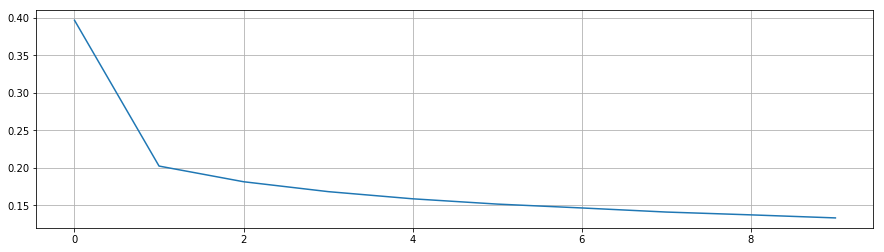

In [24]:
pl.figure(figsize=(15,4))
pl.plot(MSE)
pl.grid()

In [25]:
#get validation score
#nn = load_model("tdm1")
preds = nn.predict(validate)

loss = calc_MSE(preds, validate_target)
loss

0.17554347345263557

In [0]:
nn.save_model("relu.1")

calc_accuracy(labels_from_preds(preds), labels_from_preds(validate_target)) # we have to de-OHE the predictions and the target data

In [0]:
np.mean(procdata)


2.4332387956368016e-19

In [18]:
np.seterr(all="warn")
np.random.seed(1)
procdata = np.copy(data)
preprocess(procdata, 'zscore')

#split data
train, train_target, validate, validate_target = split(data, label)
#one hot encode targets
train_target = OHE(train_target, 10)
validate_target = OHE(validate_target, 10)
second_layer = False
relu = False
if second_layer:
  nn = MLP([128,60,30,10], [None,'logistic','logistic','tanh'])
elif relu:
  nn = MLP([128,60,10], [None, 'relu', 'relu'], False)
  start = time.time()
  MSE = nn.fit_SGD_momentum(train, train_target, learning_rate=0.001, epochs=25)
  print("{}s to train".format(time.time() - start))
else:
  nn = MLP([128,60,10], [None,'logistic','tanh'], False)
  start = time.time()
  MSE = nn.fit_SGD_momentum(train, train_target, learning_rate=0.01, epochs=25)
  print("{}s to train".format(time.time() - start))
print('loss:%f'%MSE[-1])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: RuntimeWarning: overflow encountered in exp
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: RuntimeWarning: underflow encountered in exp
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: RuntimeWarning: underflow encountered in true_divide
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:82: RuntimeWarning: underflow encountered in multiply
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:69: RuntimeWarning: underflow encountered in multiply
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:70: RuntimeWarning: underflow encountered in multiply


.

KeyboardInterrupt: ignored

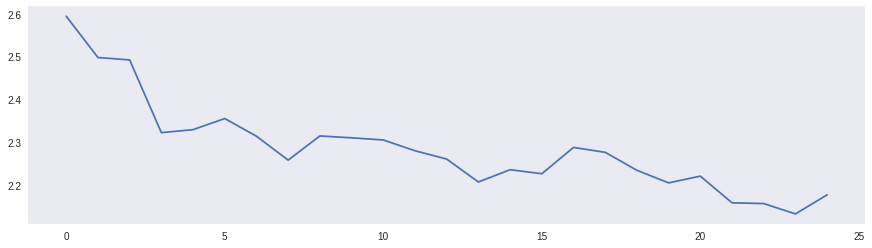

In [0]:
pl.figure(figsize=(15,4))
pl.plot(MSE)
pl.grid()

##Introduction
The experiment task consisted of building a neural network to perform multi-class classification on a supplied dataset without the use of Deep Learning frameworks (e.g. TensorFlow, Caffe, and KERAS). The dataset consisted of 60,000 labeled training samples and 10,000 unlabeled test samples. The structure of the data (e.g. image, video, etc) was unknown. The performance of the neural network was evaluated in terms of the accuracy metric. Various neural network structures and parameters were trailed to maximise speed and accuracy.

The objective of building the neural network without Deep Learning frameworks was to gain a comprehensive understanding of the math and mechanics behind neural networks.



##SGD with Momentum
Momentum ($v_t$) is an exponentially weighted average of a neural networks gradients. It is used to update the weights ($w_t$) and baises ($b_t$) of a network.

$$v_t = \beta v_{t-1} + \eta \nabla_w J(w)$$
$$w_t = w_{t-1} - v_t$$

Momentum increases for features whose gradients point in the same direction and reduces for features whose gradients change direction. By reducing the fluctuation of gradients convergence is generally sped up. The hyper-parameter $\beta$ takes a value between 0 - 1 and dictates how many samples are included in the exponential weighted average. A small $\beta$ value will increase fluctuation because the average is taken over a smaller number of examples. A large $\beta$ will increase smoothing because the average is taken over a larger number of examples. A $\beta$ value of 0.9 provides a balance between the two extremes.

##Gradient Descent
Gradient descent is a machine learning optimization method. In deep learning it is used to calculate the model parameters (weights and biases) that minimise the cost function. The gradient descent method invovles iterating through a training dataset and updating weights and baises in accordance with the gradient of error. There are three types of gradient descent. Each uses a different number of training examples to update the model parameters:
*   **Batch Gradient Descent** uses the entire training dataset to calculate gradients and update the parameters. Because the entire training dataset is considered parameters updates are smooth however, it can take a long time to make a single update.
*   **Stochastic Gradient Descent (SGD)** uses a single randomly selected sample from the training dataset to calculate gradients and update the parameters. Parameter updates are fast but very noisey.
*   **Mini-batch Gradient Descent** uses a subset of the training data (e.g. batches of 1000 samples) to calculate gradients and update the parameters. Mini-batch gradient descent is a compromise between batch and stochastic gradient descent. The mini-batch size can be adjusted to find the appropriate balance between fast convergence and noisey updates. 

Louis testing stuff below

In [0]:
np.seterr(all="warn")
np.random.seed(1)
procdata = np.copy(data)
preprocess(procdata, 'zscore')

#split data
train, train_target, validate, validate_target = split(data, label)
#one hot encode targets
train_target = OHE(train_target, 10)
validate_target = OHE(validate_target, 10)
second_layer = False
relu = False

nn = MLP([128,60,10], [None, 'tanh', 'tanh'], False)
start = time.time()
MSE = nn.fit(train, train_target, learning_rate=0.001, epochs=5)
# MSE = nn.fit_mb(train, train_target, 500, learning_rate=0.001, epochs=10)
print("{}s to train".format(time.time() - start))
print('loss:%f'%MSE[-1])

In [0]:

np.seterr(all="warn")
np.random.seed(1)
procdata = np.copy(data)
preprocess(procdata, 'zscore')

#split data
train, train_target, validate, validate_target = split(data, label)
#one hot encode targets
train_target = OHE(train_target, 10)
validate_target = OHE(validate_target, 10)
second_layer = False
relu = False
if second_layer:
  nn = MLP([128,60,30,10], [None,'logistic','logistic','tanh'])
elif relu:
  nn = MLP([128,60,10], [None, 'relu', 'relu'], False)
  start = time.time()
  MSE = nn.fit(train, train_target, learning_rate=0.001, epochs=500)
  print("{}s to train".format(time.time() - start))
else:
  nn = MLP([128,60,10], [None,'logistic','tanh'], init_uniform=False, weight_decay=0.1)
  start = time.time()
  MSE = nn.fit_mb(train, train_target,20, learning_rate=0.01, epochs=5)
  print("{}s to train".format(time.time() - start))
print('loss:%f'%MSE[-1])

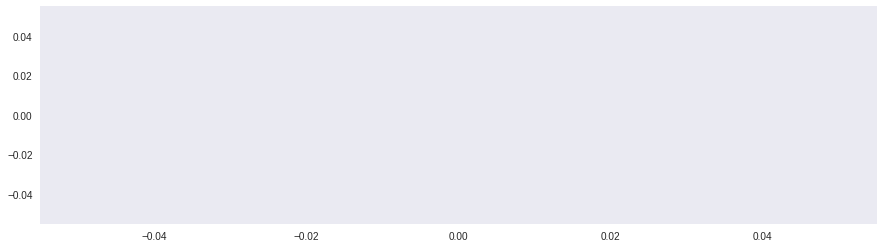

In [0]:
pl.figure(figsize=(15,4))
pl.plot(MSE)
pl.grid()

In [0]:
preds = nn.predict(validate)
calc_accuracy(labels_from_preds(preds), labels_from_preds(validate_target))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in greater


0.1

In [0]:
import numpy as np

x = np.array([[1,2], [3,4]])
w = np.array([[1,2], [3,4]])
d = np.array([1,2])
print(np.dot(x, w)+d)

[[ 8 12]
 [16 24]]


In [0]:
import numpy as np

x = np.array([1,2])
w = np.array([[1,2], [3,4]])
d = np.array([1,2])
print(np.dot(x, w)+d)
x = np.array([3,4])
print(np.dot(x, w)+d)

[ 8 12]
[16 24]
